# Phase 1: Introduction to the Project & Dataset Exploration

### Brief Description of the Dataset:

Link to the Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

#### <u>The dataset is comprised of 3 folders:<u>

1. **train** - *contains the images that the model will be trained on* (the training set)
   - **1341 images** are x-rays of **'normal'** lungs, **3875 images** are x-rays of lungs with **pneumonia**
2. **test** - *contains the images that the model will be tested on to evaluate its performance, providing guidelines for model tuning* (the test set)
   - **234 images** are x-rays of **'normal'** lungs, **390 images** are x-rays of lungs with **pneumonia**
3. **val** - *contains the images that will be used to assess the final performance of the fully trained model* (the validation set)
   - **8 images** are x-rays of **'normal'** lungs, **8 images** are x-rays of lungs with **pneumonia**

The dataset contains images of lungs with both 'bacterial' and 'viral' pneumonia, however the model will not differentiate between the two (it will simply aim to classify a given x-ray image of a lung as being infected with pneumonia or not).

### **Pointing out the class imbalance**
With a total of 5216 images in the training set, roughly **74.3%** of the images in the training set are **x-ray images of pneumonia-infected lungs**, leaving ***only around 25.7%*** of the images in the training set to be ***x-ray images of healthy lungs***. **This is quite a significant class imbalance** (almost 3x as many pneumonia infected lungs as healthy lungs) and this will need to be handled later on.

# Phase 2: Data Preprocessing

### Importing Tensorflow & the ImageDataGenerator Class

In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Preprocessing the Training Set

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


Keras' *flow_from_directory* expects a directory structure whereby the main directory (which is passed in as the first parameter) contains **subdirectories** for each class, which is how this dataset is structured. Images are then assigned a label according to the folder name (due to alphabetical order, images in 'NORMAL' are assigned 0, images in 'PNEUMONIA' are assigned 1)

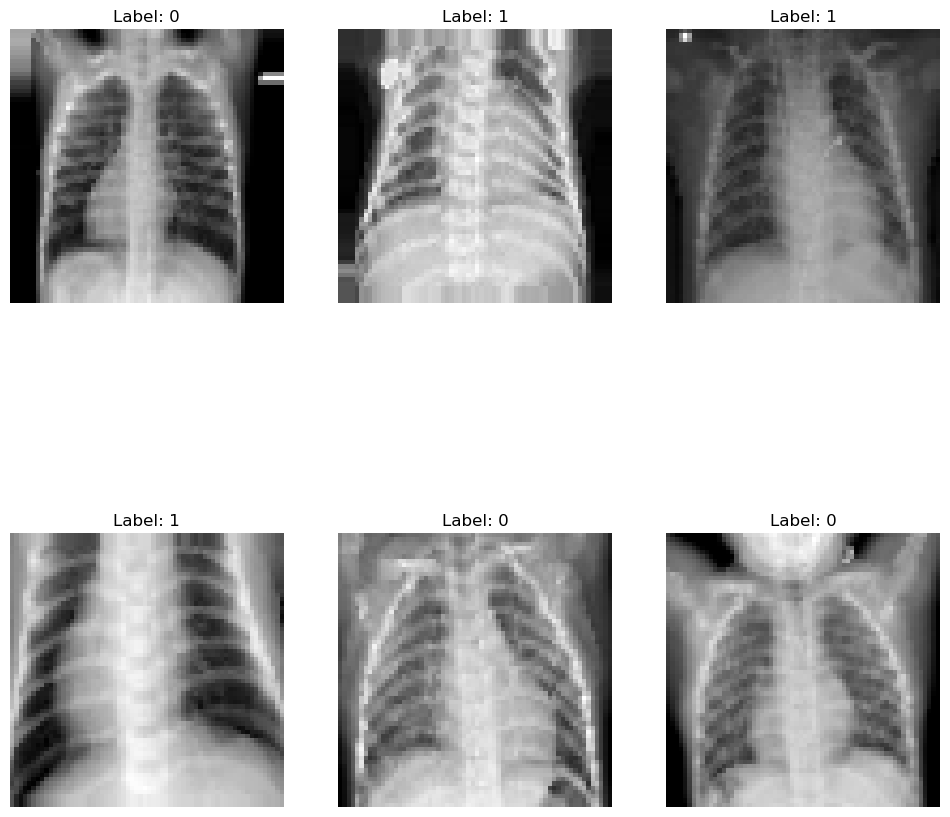

In [3]:
import matplotlib.pyplot as plt

images, labels = next(training_set)

plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {int(labels[i])}") #0 for normal, 1 for pneumonia
    plt.axis("off")
plt.show()

## 2. Preprocessing the Test Set

The test set should **not be augmented** because it should reflect *real-world conditions*, the model would be tested on **altered images** that aren't actual medical scans

In [4]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_set = test_datagen.flow_from_directory('data/test',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

Found 624 images belonging to 2 classes.


#### Handling the Class Imbalance: Using Class Weighting instead of Resampling techniques

Since the class imbalance is not too extreme, and resampling (over/undersampling) can lead to overfitting/loss of valuable information, I will proceed with *cost-sensitive learning*, by using sklearn's **compute_class_weight** function

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = np.array([0,1]) #(0 = Normal, 1 = Pneumonia)

class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = class_labels,
    y = [0]*1341 + [1]*3875)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


The CNN model to be built calculates a **loss function** which the model aims to minimize throughout subsequent epocs. With class weighting, the loss function applies **higher penalties** to misclassified samples from the *minority class* (which are the normal lungs). This handles the class imbalance by urging the model to pay more attention to the minority class (normal lungs).

# Phase 3: Model Development

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential

### 1. Convolution

In [7]:
cnn = Sequential()

In [8]:
cnn.add(Conv2D(filters=32,
               kernel_size=3,
               activation='relu',
               input_shape=(64,64,1)))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 2. Pooling

In [9]:
cnn.add(MaxPool2D(pool_size=2,
                  strides=2))

**Multiple convolution layers may be added to make the architecture more complex** - This is needed since detecting pneumonia in grayscale x-ray images is already very difficult for the human eye: The more difficult it is to detect certain the features, the greater the need for a more complex model.

In [10]:
#Second Layer:
cnn.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu'))

cnn.add(MaxPool2D(pool_size=2,
                  strides=2))

#Third Layer:
cnn.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu'))

cnn.add(MaxPool2D(pool_size=2,
                  strides=2))

### 3. Flattening

In [11]:
cnn.add(Flatten())

### 4. Full Connection

In [12]:
cnn.add(Dense(units=128,
              activation='relu'))

#final output layer
cnn.add(Dense(units=1,
              activation='sigmoid'))

In [13]:
from tensorflow.keras.metrics import Precision, Recall
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [14]:
history = cnn.fit(x=training_set, validation_data=test_set, epochs=10, class_weight = class_weight_dict)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.6806 - loss: 0.5422 - precision: 0.8704 - recall: 0.6640 - val_accuracy: 0.8478 - val_loss: 0.3551 - val_precision: 0.9086 - val_recall: 0.8410
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.8883 - loss: 0.2782 - precision: 0.9599 - recall: 0.8859 - val_accuracy: 0.8734 - val_loss: 0.2983 - val_precision: 0.8897 - val_recall: 0.9103
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.9103 - loss: 0.2322 - precision: 0.9657 - recall: 0.9103 - val_accuracy: 0.8702 - val_loss: 0.3358 - val_precision: 0.8687 - val_recall: 0.9333
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9170 - loss: 0.1997 - precision: 0.9713 - recall: 0.9150 - val_accuracy: 0.8510 - val_loss: 0.3761 - val_precision: 0.8153 - val_recall: 0.9846
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.9000 - loss: 0.2528 - precision: 0.9649 - recall: 0.8965 - val_accuracy: 0.8958

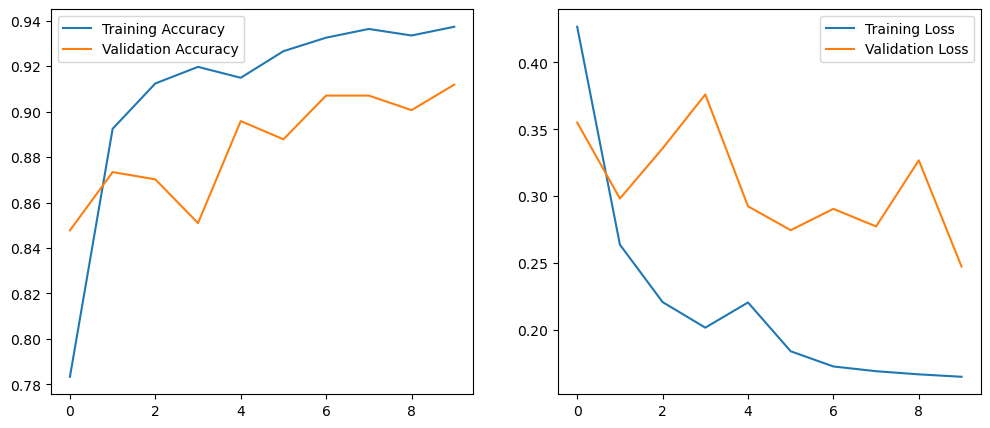

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

There are relatively erratic fluctuations in validation loss. While the fluctuations are not too significant in number, there is no 
clear downward trend: The model is clearly struggling to generalize.

The model also seems to be overfitting due to **lower validation accuracy** than training accuracy, as well as **higher validation loss** than training loss

### Precision Metrics

In [16]:
print("Training Precision:", history.history['precision'], '\n')
print("Validation Precision:", history.history['val_precision'], '\n')

Training Precision: [0.9247910976409912, 0.9633668661117554, 0.9687328338623047, 0.9729064106941223, 0.9740259647369385, 0.9770491719245911, 0.9777597188949585, 0.979431688785553, 0.9796084761619568, 0.9802381992340088] 

Validation Precision: [0.9085872769355774, 0.8897243142127991, 0.8687350749969482, 0.8152866363525391, 0.8878281712532043, 0.9102563858032227, 0.8878504633903503, 0.8990384340286255, 0.8813953399658203, 0.9156327247619629] 



The model seems to be **slightly weak** at minimizing false positives when it comes to unseen data (validation precision is quite significantly lower than training precision across all epochs)

### Recall Metrics

In [17]:
print("Training Recall:", history.history['recall'], '\n')
print("Validation Recall:", history.history['val_recall'], '\n')

Training Recall: [0.7710967659950256, 0.889032244682312, 0.911483883857727, 0.9174193739891052, 0.9096774458885193, 0.9228386878967285, 0.9303225874900818, 0.9339354634284973, 0.9298064708709717, 0.9344516396522522] 

Validation Recall: [0.8410256505012512, 0.9102563858032227, 0.9333333373069763, 0.9846153855323792, 0.9538461565971375, 0.9102563858032227, 0.9743589758872986, 0.9589743614196777, 0.971794843673706, 0.9461538195610046] 



The model seems to be **relatively strong** at detecting actual pneumonia cases when it comes to unseen data

## Model Tuning

### Trying a lower learning rate

In [18]:
#default learning rate of adam optimizer is 0.001, try 0.0005
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.0005)

cnn.compile(optimizer = adam_optimizer, loss = 'binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
history = cnn.fit(x=training_set, validation_data=test_set, epochs=15, class_weight=class_weight_dict)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 158ms/step - accuracy: 0.9418 - loss: 0.1529 - precision: 0.9822 - recall: 0.9369 - val_accuracy: 0.9151 - val_loss: 0.2606 - val_precision: 0.9021 - val_recall: 0.9692
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9421 - loss: 0.1504 - precision: 0.9815 - recall: 0.9401 - val_accuracy: 0.8990 - val_loss: 0.3106 - val_precision: 0.8759 - val_recall: 0.9769
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.9351 - loss: 0.1614 - precision: 0.9814 - recall: 0.9299 - val_accuracy: 0.9199 - val_loss: 0.2438 - val_precision: 0.9106 - val_recall: 0.9667
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.9456 - loss: 0.1415 - precision: 0.9828 - recall: 0.9423 - val_accuracy: 0.9231 - val_loss: 0.2481 - val_precision: 0.9212 - val_recall: 0.9590
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.9460 - loss: 0.1362 - precision: 0.9825 - recall: 0.9442 - val_accuracy: 0.9183

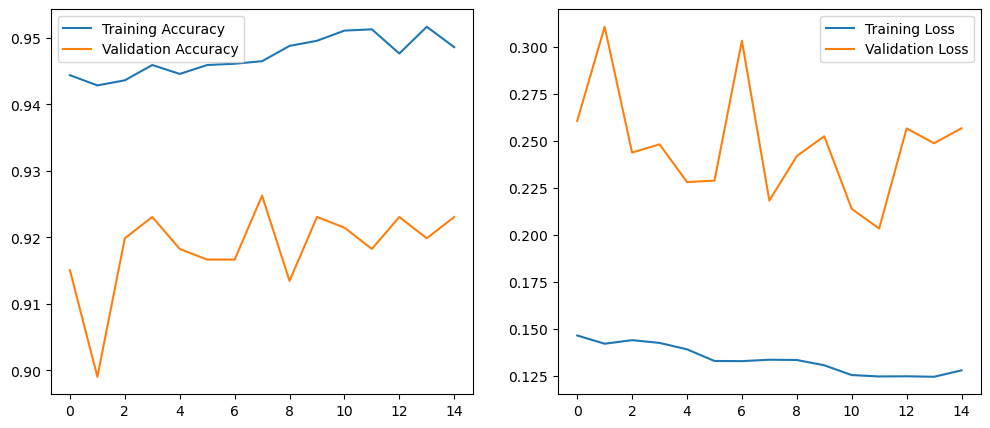

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

There are slight upward/downward trends in validation accuracy/loss respectively, however there are still erratic fluctuations - **slight improvement nonetheless**

This may suggest batch sensitivity and/or model instability - overall this shows the model is still inconsistent. Additionally, the model is still overfitting due to the significant difference between training and validation accuracy/loss

### Trying a larger batch size

In [20]:
#Try larger batch size
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64,64),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/test',
                                                 target_size = (64,64),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

cnn.compile(optimizer = adam_optimizer, loss = 'binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
history = cnn.fit(x=training_set, validation_data=test_set, epochs=15, class_weight=class_weight_dict)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 319ms/step - accuracy: 0.9566 - loss: 0.1090 - precision: 0.9864 - recall: 0.9542 - val_accuracy: 0.9295 - val_loss: 0.2241 - val_precision: 0.9179 - val_recall: 0.9744
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 314ms/step - accuracy: 0.9501 - loss: 0.1213 - precision: 0.9862 - recall: 0.9459 - val_accuracy: 0.9071 - val_loss: 0.3091 - val_precision: 0.8807 - val_recall: 0.9846
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 311ms/step - accuracy: 0.9579 - loss: 0.1130 - precision: 0.9869 - recall: 0.9552 - val_accuracy: 0.9247 - val_loss: 0.2290 - val_precision: 0.9113 - val_recall: 0.9744
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 310ms/step - accuracy: 0.9572 - loss: 0.1064 - precision: 0.9885 - recall: 0.9538 - val_accuracy: 0.9327 - val_loss: 0.1979 - val_precision: 0.9328 - val_recall: 0.9615
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 25s 305ms/step - accuracy: 0.9646 -

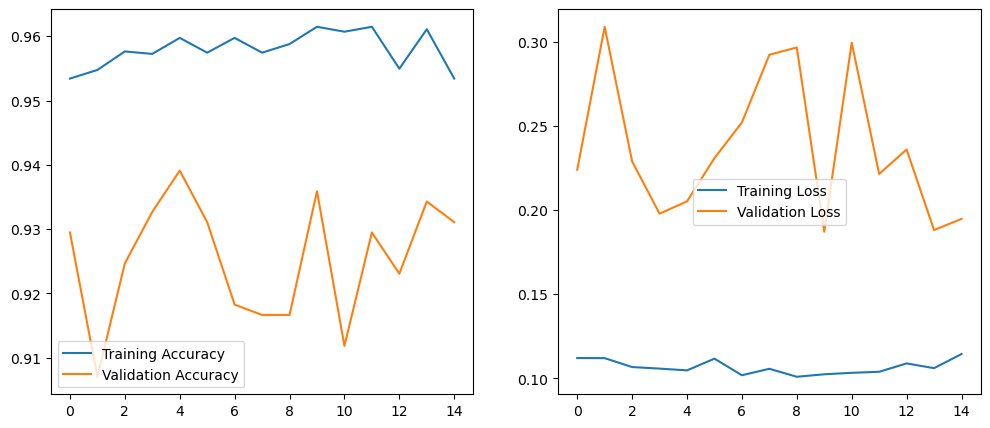

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Model seems even more unstable: This may have occured since larger batch sizes lead to **less frequent weight updates** (the model's weights update after each batch, therefore larger bathces means fewer batches = fewer updates)

In [22]:
#Reducing batch size back to 32
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/test',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Trying an even lower learning rate and introducing early stopping and L2 regularization

In [23]:
#Try lower learning rate + modify Early Stopping
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.0003) #0.0005 --> 0.0003

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) #Stop after 4 rounds

In [24]:
#Redefining model architecture with Regularization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

cnn = Sequential()

# First Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 1)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Second Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Third Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Flatten layer
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128, activation='relu'))

#Output Layer
cnn.add(Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
cnn.fit(x=training_set, validation_data=test_set, epochs=20, class_weight=class_weight_dict, callbacks=[early_stop])

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.6972 - loss: 0.6691 - precision: 0.8508 - recall: 0.7273 - val_accuracy: 0.7821 - val_loss: 0.4929 - val_precision: 0.9536 - val_recall: 0.6846
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 154ms/step - accuracy: 0.8685 - loss: 0.3513 - precision: 0.9509 - recall: 0.8700 - val_accuracy: 0.8462 - val_loss: 0.3640 - val_precision: 0.8769 - val_recall: 0.8769
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.8893 - loss: 0.3001 - precision: 0.9588 - recall: 0.8888 - val_accuracy: 0.8638 - val_loss: 0.3482 - val_precision: 0.8765 - val_recall: 0.9103
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9055 - loss: 0.2594 - precision: 0.9670 - recall: 0.9052 - val_accuracy: 0.8574 - val_loss: 0.3514 - val_precision: 0.8592 - val_recall: 0.9231
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9161 - loss: 0.2420 - precision: 0.9707 - recall: 0.9149 - val_accuracy: 0.8734

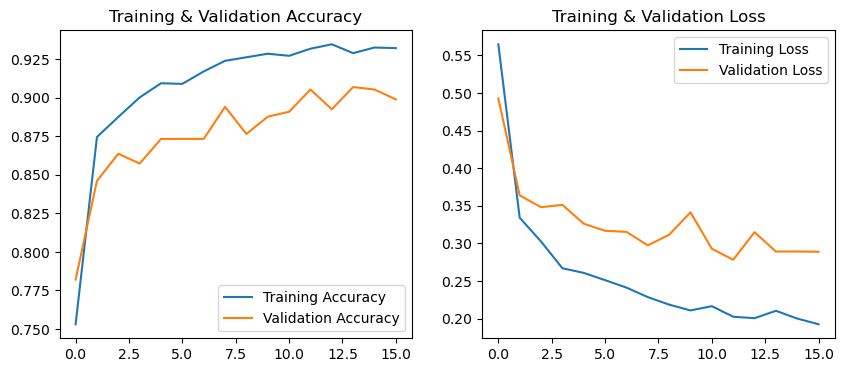

In [25]:
history = cnn.history
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

**Significant improvement**. Model looks more stable (although there are still some erratic changes in validation accuracy/loss), less overfitting (smaller difference betweeen train and validation accuracy) and there are clear upward/downward trends for validation accuracy/loss respectively.

In [26]:
print("Training Precision:", history.history['precision'], '\n')
print("Validation Precision:", history.history['val_precision'], '\n')

print("Training Recall:", history.history['recall'], '\n')
print("Validation Recall:", history.history['val_recall'], '\n')

Training Precision: [0.900836706161499, 0.9543018341064453, 0.9602574706077576, 0.9648101925849915, 0.9709382653236389, 0.9696216583251953, 0.9743731021881104, 0.9764447808265686, 0.9770429134368896, 0.9773780107498169, 0.9768139719963074, 0.97826087474823, 0.9793870449066162, 0.9750609993934631, 0.9808952212333679, 0.9793140888214111] 

Validation Precision: [0.9535714387893677, 0.8769230842590332, 0.8765432238578796, 0.8591885566711426, 0.8997429013252258, 0.9146666526794434, 0.912466824054718, 0.8990147709846497, 0.9151193499565125, 0.8652967810630798, 0.9107142686843872, 0.9046455025672913, 0.8712643384933472, 0.9088670015335083, 0.8987951874732971, 0.9118387699127197] 

Training Recall: [0.7501935362815857, 0.87303227186203, 0.8854193687438965, 0.8985806703567505, 0.9052903056144714, 0.906064510345459, 0.9125161170959473, 0.9200000166893005, 0.9225806593894958, 0.9254193305969238, 0.9241290092468262, 0.9290322661399841, 0.9318709969520569, 0.9282580614089966, 0.927483856678009, 0.

### Introducing a Dropout Layer

In [30]:
cnn = Sequential()
 
# First Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 1)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Second Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Third Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Flatten layer
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128, activation='relu'))

#Output Layer
cnn.add(Dense(units=1, activation='sigmoid'))
cnn.add(Dropout(0.3))

adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0003)

cnn.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
cnn.fit(x=training_set, validation_data=test_set, epochs=20, class_weight=class_weight_dict, callbacks=[early_stop])

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.4781 - loss: 2.8851 - precision: 0.8261 - recall: 0.3683 - val_accuracy: 0.6234 - val_loss: 0.6699 - val_precision: 0.9936 - val_recall: 0.4000
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.6620 - loss: 2.6894 - precision: 0.9482 - recall: 0.5708 - val_accuracy: 0.6843 - val_loss: 0.6251 - val_precision: 0.9898 - val_recall: 0.5000
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.6777 - loss: 2.6709 - precision: 0.9603 - recall: 0.5952 - val_accuracy: 0.7356 - val_loss: 0.5359 - val_precision: 0.9747 - val_recall: 0.5923
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.6840 - loss: 2.6577 - precision: 0.9693 - recall: 0.5944 - val_accuracy: 0.7981 - val_loss: 0.4650 - val_precision: 0.9648 - val_recall: 0.7026
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.6914 - loss: 2.7255 - precision: 0.9738 - recall: 0.6013 - val_accuracy: 0.7724

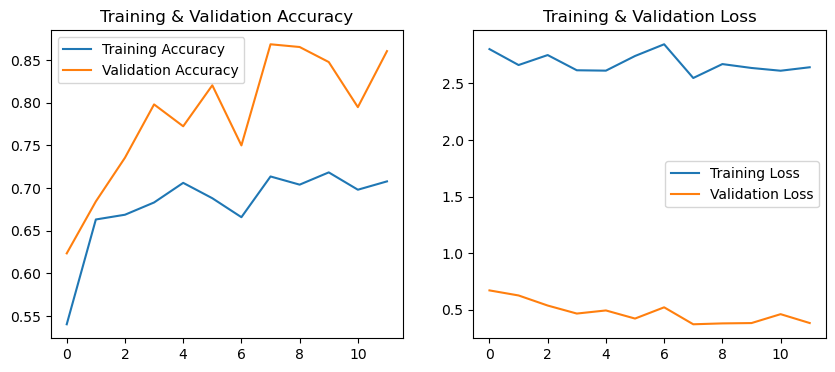

In [31]:
history = cnn.history
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

**Very Unexpected Results** - validation accuracy is higher than training accuracy

This may suggest that the model is **struggling to learn** and the dropout *may be too aggressive*

In [33]:
cnn = Sequential()
 
# First Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 1)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Second Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Third Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Flatten layer
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128, activation='relu'))

#Output Layer
cnn.add(Dense(units=1, activation='sigmoid'))
cnn.add(Dropout(0.2))#reduced dropout rate from 0.3 to 0.2

adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0003)

cnn.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
cnn.fit(x=training_set, validation_data=test_set, epochs=20, class_weight=class_weight_dict)#removed early stopping for full training

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.5588 - loss: 2.1862 - precision: 0.8430 - recall: 0.5000 - val_accuracy: 0.7837 - val_loss: 0.5126 - val_precision: 0.9126 - val_recall: 0.7231
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 155ms/step - accuracy: 0.7131 - loss: 2.0336 - precision: 0.9512 - recall: 0.6454 - val_accuracy: 0.8125 - val_loss: 0.4593 - val_precision: 0.9200 - val_recall: 0.7667
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.7245 - loss: 1.9475 - precision: 0.9637 - recall: 0.6564 - val_accuracy: 0.7340 - val_loss: 0.5549 - val_precision: 0.9375 - val_recall: 0.6154
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.7462 - loss: 1.9659 - precision: 0.9629 - recall: 0.6851 - val_accuracy: 0.8077 - val_loss: 0.4578 - val_precision: 0.9383 - val_recall: 0.7410
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 156ms/step - accuracy: 0.7427 - loss: 1.8499 - precision: 0.9752 - recall: 0.6729 - val_accuracy: 0.8237

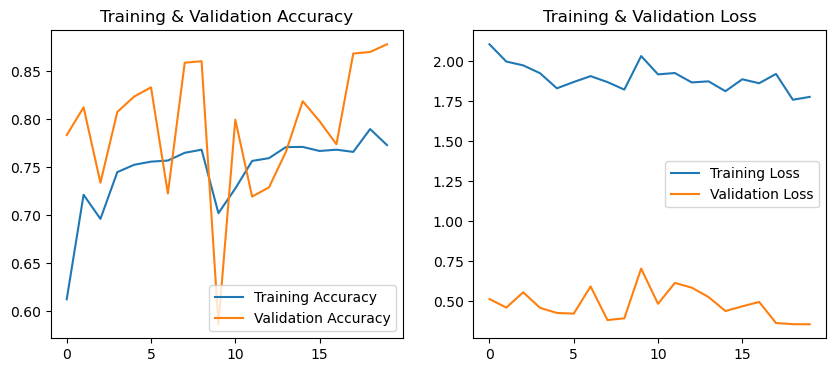

In [34]:
history = cnn.history
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

It seems that incorporating a dropout layer poses some issues, I will revert back to the original model and optimize it

## Increasing Image Size + Removing Dropout Layer

In [35]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (128,128), #from 64x64 --> 128x128
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_set = test_datagen.flow_from_directory('data/test',
                                            target_size = (128,128), #from 64x64 --> 128x128
                                            batch_size = 32,
                                            color_mode = 'grayscale',
                                            class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [38]:
cnn = Sequential()
 
# First Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(128, 128, 1))) #input shape must be modified
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Second Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Third Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Flatten layer
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128, activation='relu'))

#Output Layer
cnn.add(Dense(units=1, activation='sigmoid'))

adam_optimizer = tensorflow.keras.optimizers.Adam(learning_rate=0.0003)

cnn.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
cnn.fit(x=training_set, validation_data=test_set, epochs=20, class_weight=class_weight_dict) #removed early stopping for full training

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 184ms/step - accuracy: 0.6800 - loss: 0.6223 - precision: 0.8718 - recall: 0.6638 - val_accuracy: 0.7949 - val_loss: 0.4799 - val_precision: 0.9746 - val_recall: 0.6897
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 30s 183ms/step - accuracy: 0.8866 - loss: 0.3239 - precision: 0.9609 - recall: 0.8845 - val_accuracy: 0.8766 - val_loss: 0.3428 - val_precision: 0.8808 - val_recall: 0.9282
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 210ms/step - accuracy: 0.8964 - loss: 0.2849 - precision: 0.9658 - recall: 0.8924 - val_accuracy: 0.8718 - val_loss: 0.3652 - val_precision: 0.8588 - val_recall: 0.9513
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 32s 197ms/step - accuracy: 0.9034 - loss: 0.2800 - precision: 0.9664 - recall: 0.8999 - val_accuracy: 0.8654 - val_loss: 0.3353 - val_precision: 0.9371 - val_recall: 0.8410
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 34s 207ms/step - accuracy: 0.9169 - loss: 0.2270 - precision: 0.9787 - recall: 0.9076 - val_accuracy: 0.8974

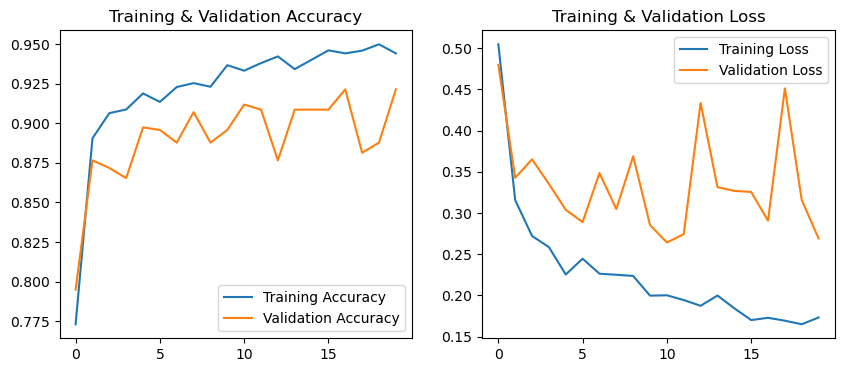

In [39]:
history = cnn.history
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

Training is still rather consistent, however the metrics are acceptable

## Making a Single Prediction

In [60]:
from keras.preprocessing import image

img = image.load_img('data/val/PNEUMONIA/person1954_bacteria_4886.jpeg', target_size=(128, 128), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = cnn.predict(img_array)
class_label = "Pneumonia" if prediction > 0.5 else "Normal"

print(f"Prediction: {class_label} (Confidence: {max(prediction[0][0], 1-prediction[0][0]):.2%})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Prediction: Pneumonia (Confidence: 94.77%)


- Model Predicts 6/8 Normal Lungs **correctly** in the Validation Set
- Model Predicts 7/8 Pneumonia Lungs **correctly** in the Validation Set

## Saving the model

In [61]:
cnn.save("../../web-app/david-boules/model.keras")

# References:

- Data Augmentation Techniques: https://www.linkedin.com/advice/0/how-do-you-implement-data-augmentation-techniques
- Handling Class Imbalance in Image Classification: Techniques and Best Practices: https://medium.com/@okeshakarunarathne/handling-class-imbalance-in-image-classification-techniques-and-best-practices-c539214440b0
- Handling Class Imbalances using Class Weights: https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4
- The Ultimate Guide to Convolutional Neural Networks: https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn
- Building a Convolutional Neural Network using TensorFlow: https://www.analyticsvidhya.com/blog/2021/06/building-a-convolutional-neural-network-using-tensorflow-keras/
- Fixing Overfitting on a CNN: https://www.geeksforgeeks.org/what-are-the-possible-approaches-to-fixing-overfitting-on-a-cnn/
- Regularization in Deep Learning: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/